# Factor Allocation - Quick Analysis

**Simplified notebook** with configurable analysis axes and **grid search**.

## Default Configuration
- **Strategy**: Supervised
- **Allocation**: Multi (6 factors)
- **Horizons**: 1M, 12M
- **Config**: Feature Selection (fs)
- **Ensemble**: WF Ensemble

## Grid Search
Optimizes `N_FEATURES` and `sequence_length` via walk-forward validation.
Set `RUN_GRID_SEARCH = True` to enable.

In [1]:
# ============================================================
# IMPORTS & SETUP
# ============================================================
%matplotlib inline

import sys
import warnings
import importlib
from pathlib import Path

warnings.filterwarnings('ignore')

# Setup project path
project_root = Path.cwd().parent
if str(project_root / "src") not in sys.path:
    sys.path.insert(0, str(project_root / "src"))

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Project imports
from data.point_in_time_loader import PointInTimeFREDMDLoader, PointInTimeConfig
from data.factor_data_loader import FactorDataLoader, FactorDataConfig
from data.data_loader import Region
from features.feature_engineering import FeatureEngineer, FeatureConfig
from comparison_runner import prepare_data, compute_composite_score
from pipelines import ThreeStepEvaluation
from pipelines.three_step_pipeline import EvaluationConfig
from visualization import plot_all_walk_forward, plot_all_holdout
from visualization.walk_forward_plots import print_year_summary_table
from visualization.holdout_plots import print_holdout_summary_table
from utils.benchmarks import compute_all_benchmarks
from utils.keys import unpack_key
from utils.analysis import print_best_models_table, print_model_comparison_summary

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

print(f"Project root: {project_root}")
print("Setup complete")

Project root: /Users/mathis/Finance-Quant-thinking/Strategies/factor_allocation_strategy_macro
Setup complete


In [2]:
# ============================================================
# DATA LOADING
# ============================================================

vintages_dir = project_root / "data_cache" / "vintages"

pit_loader = PointInTimeFREDMDLoader(
    PointInTimeConfig(
        vintages_dir=vintages_dir,
        publication_lag=1,
        apply_transformations=True
    )
)

macro_data = pit_loader.create_pit_macro_dataframe(
    start_date="2000-01-01",
    end_date="2024-12-31"
)

market_data = pit_loader.create_pit_market_context(
    start_date="2000-01-01",
    end_date="2024-12-31"
)

indicators = pit_loader.get_indicators()

factor_loader = FactorDataLoader(
    FactorDataConfig(
        start_date="2000-01-01",
        end_date="2024-12-31",
        cache_dir=project_root / "data_cache" / "factors",
        use_cache=True
    )
)

factor_data = factor_loader.load_all_factors()

print(f"Data loaded: {len(macro_data)} macro obs, {len(factor_data)} factor obs")

Indexed 305 vintage files
  Coverage: 1999-08 to 2024-12
Loading cached all factors from /Users/mathis/Finance-Quant-thinking/Strategies/factor_allocation_strategy_macro/data_cache/factors/all_factors.parquet
Data loaded: 32799 macro obs, 288 factor obs


---
## Grid Search for Hyperparameters

Search for optimal `N_FEATURES` and `sequence_length` using walk-forward validation.

In [8]:
# ============================================================
# GRID SEARCH CONFIGURATION
# ============================================================
# Set RUN_GRID_SEARCH = True to search for optimal parameters
# Set RUN_GRID_SEARCH = False to skip and use default/best parameters

RUN_GRID_SEARCH = True

# --- Parameter Grids ---
N_FEATURES_GRID = [15, 30, 50]          # Number of features to select
SEQUENCE_LENGTH_GRID = [6, 12, 24]      # Sequence length for transformer

# --- Evaluation Settings (for which config to find best params) ---
# These define WHICH strategy/allocation/horizon to optimize for
GS_STRATEGY = "Sup"                     # Single strategy for grid search
GS_ALLOCATION = "Multi"                 # Single allocation for grid search  
GS_HORIZON = 12                         # Single horizon for grid search
GS_VERBOSE = False                      # Reduce output during search

# Total combinations
n_param_combos = len(N_FEATURES_GRID) * len(SEQUENCE_LENGTH_GRID)
print(f"Grid Search Configuration:")
print(f"  Parameter grid: {n_param_combos} combos ({len(N_FEATURES_GRID)} n_features × {len(SEQUENCE_LENGTH_GRID)} seq_len)")
print(f"  Evaluating for: {GS_STRATEGY}-{GS_ALLOCATION}-{GS_HORIZON}M")
print(f"\n  N_FEATURES: {N_FEATURES_GRID}")
print(f"  sequence_length: {SEQUENCE_LENGTH_GRID}")

Grid Search Configuration:
  Parameter grid: 9 combos (3 n_features × 3 seq_len)
  Evaluating for: Sup-Multi-12M

  N_FEATURES: [15, 30, 50]
  sequence_length: [6, 12, 24]


In [11]:
# ============================================================
# GRID SEARCH EXECUTION
# ============================================================

grid_search_results = []

if RUN_GRID_SEARCH:
    print("=" * 80)
    print(f"GRID SEARCH: N_FEATURES × sequence_length")
    print(f"Optimizing for: {GS_STRATEGY}-{GS_ALLOCATION}-{GS_HORIZON}M")
    print("=" * 80)
    
    total_combos = len(N_FEATURES_GRID) * len(SEQUENCE_LENGTH_GRID)
    combo_idx = 0
    
    for n_feat in N_FEATURES_GRID:
        for seq_len in SEQUENCE_LENGTH_GRID:
            combo_idx += 1
            print(f"\n[{combo_idx}/{total_combos}] N_FEATURES={n_feat}, sequence_length={seq_len}")
            
            # Create model config with current sequence_length
            gs_model_config = {
                "sequence_length": seq_len,
                "num_factors": 6,
                "d_model": 32,
                "num_heads": 1,
                "num_layers": 1,
                "d_ff": 64,
                "dropout": 0.75,
                "learning_rate": 0.0005,
                "batch_size": 64,
                "weight_decay": 0.05,
                "epochs_phase1": 20,
                "epochs_phase2": 15,
                "epochs_phase3": 15,
                "execution_threshold": 0.05,
                "transaction_cost": 0.001,
                "val_split": 0.2,
                "early_stopping": True,
                "early_stopping_patience": 5,
            }
            
            # Create feature engineer with current sequence_length
            gs_feature_config = FeatureConfig(
                sequence_length=seq_len,
                include_momentum=True,
                include_market_context=True,
                use_fred_md=True,
                aggregation_windows=[1, 3, 6, 12]
            )
            
            gs_feature_engineer = FeatureEngineer(
                config=gs_feature_config,
                region=Region.US,
                fred_md_indicators=indicators
            )
            
            # Create evaluation config - SINGLE strategy/allocation/horizon
            gs_eval_config = EvaluationConfig(
                holdout_years=3,
                holdout_start_date="2022-01-01",
                horizons=[GS_HORIZON],
                save_models=False,
                verbose=GS_VERBOSE,
                train_fair_ensemble=False,
                run_bias_analysis=False,
                configs_to_run=["fs"],
                n_features=n_feat,
                selection_method="mutual_info",
                hp_tuning_trials=0,
                strategies=[GS_STRATEGY],
                allocations=[GS_ALLOCATION],
            )
            
            try:
                # Create evaluator and run walk-forward only
                gs_evaluator = ThreeStepEvaluation(
                    macro_data=macro_data,
                    factor_data=factor_data,
                    market_data=market_data,
                    indicators=indicators,
                    feature_engineer=gs_feature_engineer,
                    model_config=gs_model_config,
                    factor_loader=factor_loader,
                    eval_config=gs_eval_config,
                )
                
                # Run only walk-forward (faster than full 3-step)
                gs_evaluator.run_step1_walk_forward()
                
                # Get summary - should have exactly 1 row
                wf_summary = gs_evaluator._build_walk_forward_summary()
                
                if len(wf_summary) > 0:
                    row = wf_summary.iloc[0]
                    score = row['score']
                    sharpe = row['true_oos_sharpe']
                    ic = row['avg_ic']
                    maxdd = row['true_oos_maxdd']
                else:
                    score, sharpe, ic, maxdd = 0, 0, 0, 0
                
                grid_search_results.append({
                    'n_features': n_feat,
                    'sequence_length': seq_len,
                    'score': score,
                    'sharpe': sharpe,
                    'ic': ic,
                    'maxdd': maxdd,
                })
                
                print(f"  -> Score: {score:.4f}, Sharpe: {sharpe:+.4f}, IC: {ic:+.4f}, MaxDD: {maxdd:+.4f}")
                
            except Exception as e:
                print(f"  -> ERROR: {e}")
                grid_search_results.append({
                    'n_features': n_feat,
                    'sequence_length': seq_len,
                    'score': -999,
                    'sharpe': 0,
                    'ic': 0,
                    'maxdd': 0,
                })
    
    print("\n" + "=" * 80)
    print("GRID SEARCH COMPLETE")
    print("=" * 80)
else:
    print("Grid search skipped (RUN_GRID_SEARCH = False)")

GRID SEARCH: N_FEATURES × sequence_length
Optimizing for: Sup-Multi-12M

[1/9] N_FEATURES=15, sequence_length=6

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}
  -> Score: 0.4223, Sharpe: +0.6175, IC: +0.0158, MaxDD: -0.0991

[2/9] N_FEATURES=15, sequence_length=12

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}
  -> Score: 0.4148, Sharpe: +0.5618, IC: +0.0402, MaxDD: -0.1050

[3/9] N_FEATURES=15, sequence_length=24

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}
  -> Score: 0.3930, Sharpe: +0.4974, IC: +0.0029, MaxDD: -0.1069

[4/9] N_FEATURES=30, sequence_length=6

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}
  -> Score: 0.4335, Sharpe: +0.5629, IC: +0.1134, MaxDD: -0.1047

[5/9] N_FEATURES=30, sequence_length=12

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}
  -> Score

GRID SEARCH RESULTS (Sup-Multi-12M)

 rank  n_features  sequence_length    score   sharpe       ic     maxdd
    1          50                6 0.472944 0.643383 0.195376 -0.097368
    2          30                6 0.433472 0.562872 0.113442 -0.104739
    3          15                6 0.422339 0.617508 0.015817 -0.099138
    4          15               12 0.414822 0.561786 0.040186 -0.104960
    5          50               12 0.414681 0.482055 0.098659 -0.106190
    6          50               24 0.394162 0.420054 0.077268 -0.112859
    7          15               24 0.392972 0.497381 0.002851 -0.106862
    8          30               12 0.385529 0.453836 0.015817 -0.111586
    9          30               24 0.379487 0.427731 0.012185 -0.112466

--------------------------------------------------------------------------------
BEST PARAMETERS for Sup-Multi-12M:
  N_FEATURES = 50
  sequence_length = 6
  Score = 0.4729
  Sharpe = +0.6434
--------------------------------------------------

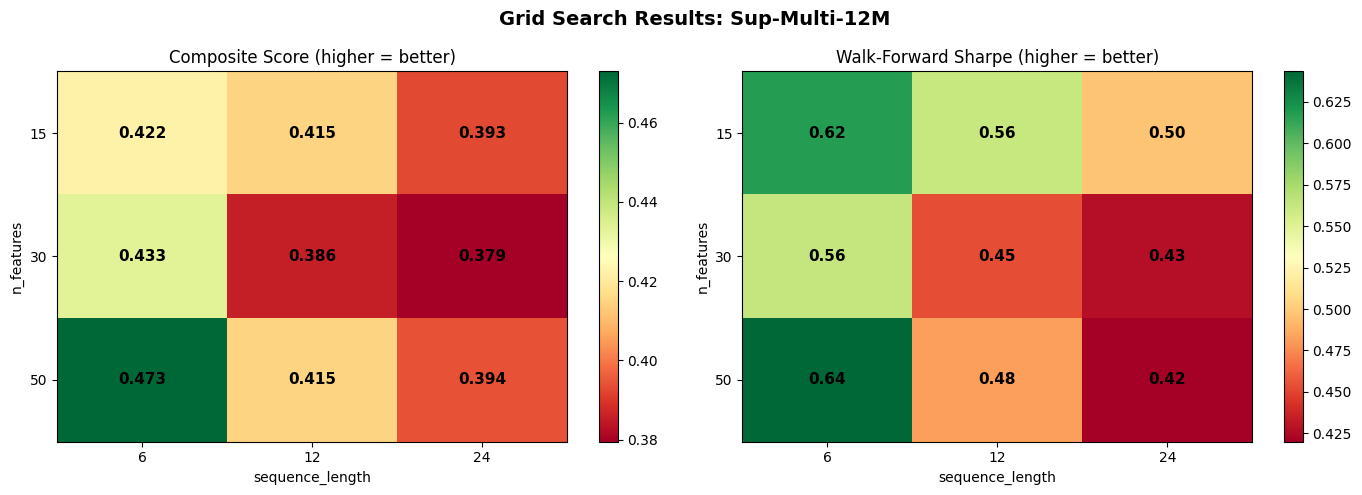

In [12]:
# ============================================================
# GRID SEARCH RESULTS
# ============================================================

if RUN_GRID_SEARCH and grid_search_results:
    # Create DataFrame
    gs_df = pd.DataFrame(grid_search_results)
    gs_df = gs_df.sort_values('score', ascending=False).reset_index(drop=True)
    gs_df['rank'] = range(1, len(gs_df) + 1)
    
    # Best parameters
    best_params = gs_df.iloc[0]
    BEST_N_FEATURES = int(best_params['n_features'])
    BEST_SEQUENCE_LENGTH = int(best_params['sequence_length'])
    
    print("=" * 80)
    print(f"GRID SEARCH RESULTS ({GS_STRATEGY}-{GS_ALLOCATION}-{GS_HORIZON}M)")
    print("=" * 80)
    
    # Display table
    print("\n" + gs_df[['rank', 'n_features', 'sequence_length', 'score', 'sharpe', 'ic', 'maxdd']].to_string(index=False))
    
    print("\n" + "-" * 80)
    print(f"BEST PARAMETERS for {GS_STRATEGY}-{GS_ALLOCATION}-{GS_HORIZON}M:")
    print(f"  N_FEATURES = {BEST_N_FEATURES}")
    print(f"  sequence_length = {BEST_SEQUENCE_LENGTH}")
    print(f"  Score = {best_params['score']:.4f}")
    print(f"  Sharpe = {best_params['sharpe']:+.4f}")
    print("-" * 80)
    
    # Heatmap visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"Grid Search Results: {GS_STRATEGY}-{GS_ALLOCATION}-{GS_HORIZON}M", fontsize=14, fontweight='bold')
    
    # Pivot for heatmaps
    score_pivot = gs_df.pivot(index='n_features', columns='sequence_length', values='score')
    sharpe_pivot = gs_df.pivot(index='n_features', columns='sequence_length', values='sharpe')
    
    # Score heatmap
    ax1 = axes[0]
    im1 = ax1.imshow(score_pivot.values, cmap='RdYlGn', aspect='auto')
    ax1.set_xticks(range(len(score_pivot.columns)))
    ax1.set_xticklabels(score_pivot.columns)
    ax1.set_yticks(range(len(score_pivot.index)))
    ax1.set_yticklabels(score_pivot.index)
    ax1.set_xlabel('sequence_length')
    ax1.set_ylabel('n_features')
    ax1.set_title('Composite Score (higher = better)')
    for i in range(len(score_pivot.index)):
        for j in range(len(score_pivot.columns)):
            val = score_pivot.values[i, j]
            ax1.text(j, i, f'{val:.3f}', ha='center', va='center', fontsize=11, fontweight='bold')
    plt.colorbar(im1, ax=ax1)
    
    # Sharpe heatmap
    ax2 = axes[1]
    im2 = ax2.imshow(sharpe_pivot.values, cmap='RdYlGn', aspect='auto')
    ax2.set_xticks(range(len(sharpe_pivot.columns)))
    ax2.set_xticklabels(sharpe_pivot.columns)
    ax2.set_yticks(range(len(sharpe_pivot.index)))
    ax2.set_yticklabels(sharpe_pivot.index)
    ax2.set_xlabel('sequence_length')
    ax2.set_ylabel('n_features')
    ax2.set_title('Walk-Forward Sharpe (higher = better)')
    for i in range(len(sharpe_pivot.index)):
        for j in range(len(sharpe_pivot.columns)):
            val = sharpe_pivot.values[i, j]
            ax2.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=11, fontweight='bold')
    plt.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
else:
    # Default values if grid search was skipped
    BEST_N_FEATURES = 30
    BEST_SEQUENCE_LENGTH = 12
    print("Using default parameters:")
    print(f"  N_FEATURES = {BEST_N_FEATURES}")
    print(f"  sequence_length = {BEST_SEQUENCE_LENGTH}")

In [13]:
# ============================================================
# CONFIGURATION (ADJUSTABLE)
# ============================================================
# Modify these variables to change the analysis scope
# Note: N_FEATURES and sequence_length use BEST values from grid search if run

# --- ANALYSIS AXES (defaults: Supervised, Multi, 1M/12M, fs) ---
STRATEGIES = ["Sup"]       # Options: ["E2E"], ["Sup"], ["E2E", "Sup"]
ALLOCATIONS = ["Multi"]    # Options: ["Binary"], ["Multi"], ["Binary", "Multi"]
HORIZONS = [1, 12]         # Options: any subset of [1, 3, 6, 12]
CONFIGS = ["fs"]           # Options: ["baseline"], ["fs"], ["hpt"], ["fs+hpt"], or combinations

# --- ENSEMBLE SETTINGS ---
USE_FAIR_ENSEMBLE = False  # True = train Fair Ensemble, False = WF Ensemble only
FAIR_ENSEMBLE_N_MODELS = 5

# --- FEATURE SELECTION SETTINGS ---
# Use best values from grid search, or defaults if grid search was skipped
N_FEATURES = BEST_N_FEATURES if 'BEST_N_FEATURES' in dir() else 30
SELECTION_METHOD = "mutual_info"  # "mutual_info" or "f_classif"

# --- HP TUNING SETTINGS (if "hpt" or "fs+hpt" in CONFIGS) ---
HP_TUNING_TRIALS = 15

# --- MODEL CONFIG ---
# Use best sequence_length from grid search, or default if skipped
_seq_len = BEST_SEQUENCE_LENGTH if 'BEST_SEQUENCE_LENGTH' in dir() else 12

MODEL_CONFIG = {
    "sequence_length": _seq_len,
    "num_factors": 6,
    "d_model": 32,
    "num_heads": 1,
    "num_layers": 1,
    "d_ff": 64,
    "dropout": 0.75,
    "learning_rate": 0.0005,
    "batch_size": 64,
    "weight_decay": 0.05,
    "epochs_phase1": 20,
    "epochs_phase2": 15,
    "epochs_phase3": 15,
    "execution_threshold": 0.05,
    "transaction_cost": 0.001,
    "val_split": 0.2,
    "early_stopping": True,
    "early_stopping_patience": 5,
}

# --- Feature Engineer ---
feature_config = FeatureConfig(
    sequence_length=_seq_len,
    include_momentum=True,
    include_market_context=True,
    use_fred_md=True,
    aggregation_windows=[1, 3, 6, 12]
)

feature_engineer = FeatureEngineer(
    config=feature_config,
    region=Region.US,
    fred_md_indicators=indicators
)

# --- Summary ---
n_combos = len(STRATEGIES) * len(ALLOCATIONS) * len(HORIZONS) * len(CONFIGS)
print("=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"Strategies:  {STRATEGIES}")
print(f"Allocations: {ALLOCATIONS}")
print(f"Horizons:    {HORIZONS}")
print(f"Configs:     {CONFIGS}")
print(f"Fair Ensemble: {USE_FAIR_ENSEMBLE}")
print(f"\nParameters (from grid search):")
print(f"  N_FEATURES: {N_FEATURES}")
print(f"  sequence_length: {_seq_len}")
print(f"\nTotal combinations: {n_combos}")
print("=" * 60)

CONFIGURATION
Strategies:  ['Sup']
Allocations: ['Multi']
Horizons:    [1, 12]
Configs:     ['fs']
Fair Ensemble: False

Parameters (from grid search):
  N_FEATURES: 50
  sequence_length: 6

Total combinations: 2


In [14]:
# ============================================================
# RUN 3-STEP EVALUATION
# ============================================================

# Build evaluation config
eval_config = EvaluationConfig(
    holdout_years=3,
    holdout_start_date="2022-01-01",
    horizons=HORIZONS,
    save_models=True,
    verbose=False,
    # Fair Ensemble
    train_fair_ensemble=USE_FAIR_ENSEMBLE,
    fair_ensemble_n_models=FAIR_ENSEMBLE_N_MODELS,
    fair_ensemble_base_seed=42,
    fair_ensemble_seed_step=100,
    # Bias analysis disabled for quick runs
    run_bias_analysis=False,
    # FS/HPT config
    configs_to_run=CONFIGS,
    n_features=N_FEATURES,
    selection_method=SELECTION_METHOD,
    hp_tuning_trials=HP_TUNING_TRIALS,
    # Strategy/Allocation filters
    strategies=STRATEGIES,
    allocations=ALLOCATIONS,
)

# Create evaluator
evaluator = ThreeStepEvaluation(
    macro_data=macro_data,
    factor_data=factor_data,
    market_data=market_data,
    indicators=indicators,
    feature_engineer=feature_engineer,
    model_config=MODEL_CONFIG,
    factor_loader=factor_loader,
    eval_config=eval_config,
)

# Run all 3 steps
print("\n" + "=" * 80)
print("STEP 1: WALK-FORWARD VALIDATION")
print("=" * 80)
evaluator.run_step1_walk_forward()
all_wf_results = evaluator.wf_results

print("\n" + "=" * 80)
print("STEP 2: TRAIN FINAL MODELS")
print("=" * 80)
evaluator.run_step2_final_models()

print("\n" + "=" * 80)
print("STEP 3: HOLDOUT EVALUATION")
print("=" * 80)
evaluator.run_step3_holdout()
all_holdout_results = evaluator.holdout_results

print("\n" + "=" * 80)
print("EVALUATION COMPLETE")
print("=" * 80)


Horizon 1M: 287 observations
  Target distribution: {1: np.int64(149), 0: np.int64(138)}

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}

STEP 1: WALK-FORWARD VALIDATION

STEP 2: TRAIN FINAL MODELS

STEP 3: HOLDOUT EVALUATION

EVALUATION COMPLETE



WALK-FORWARD SUMMARY (2017-2021)


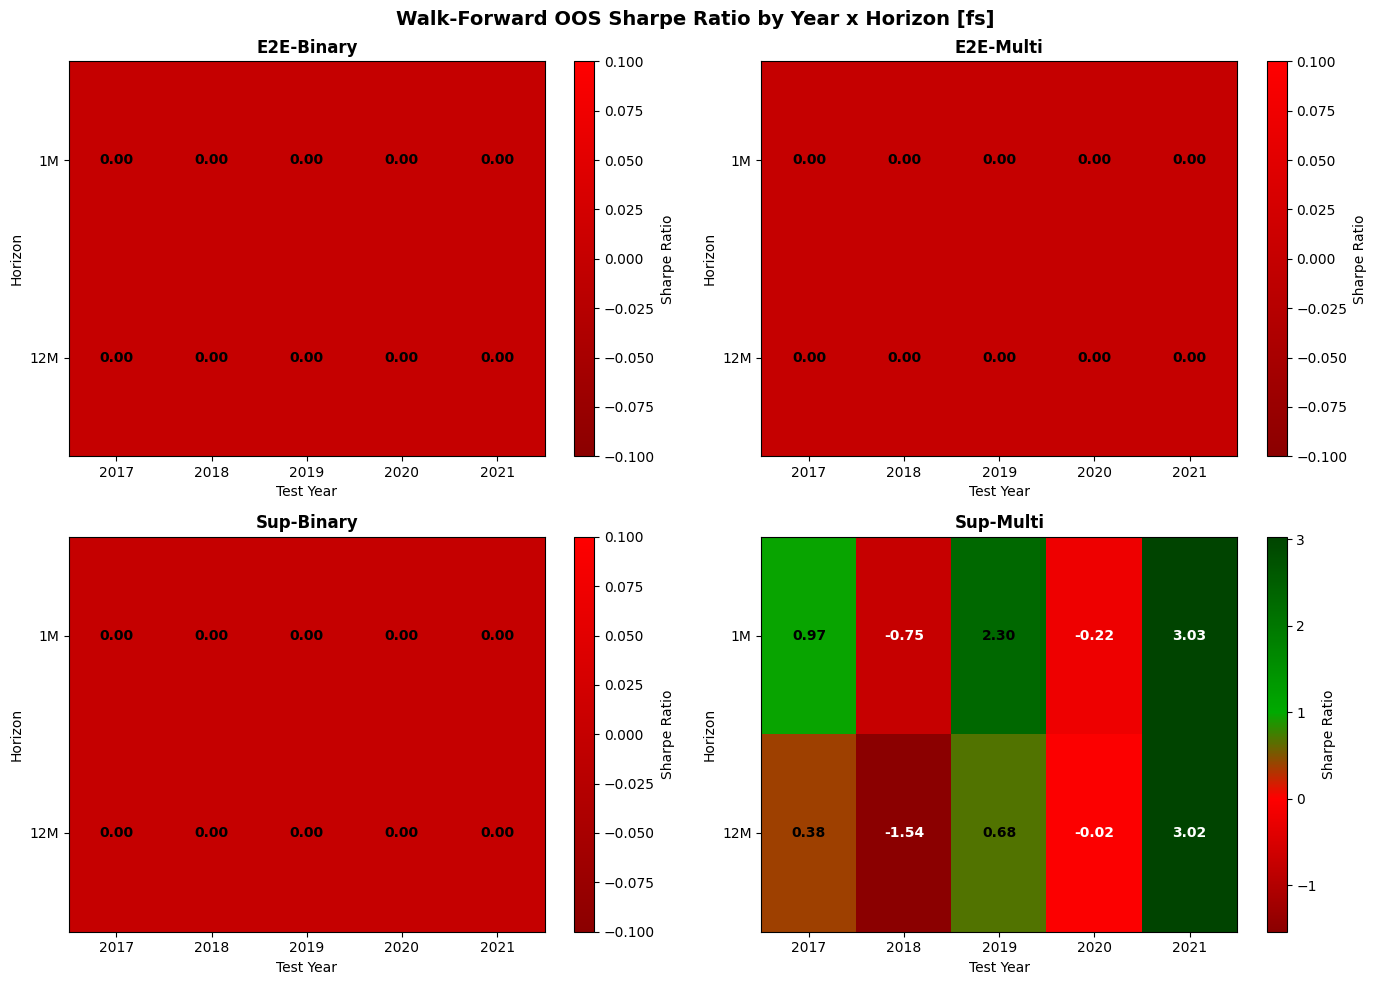

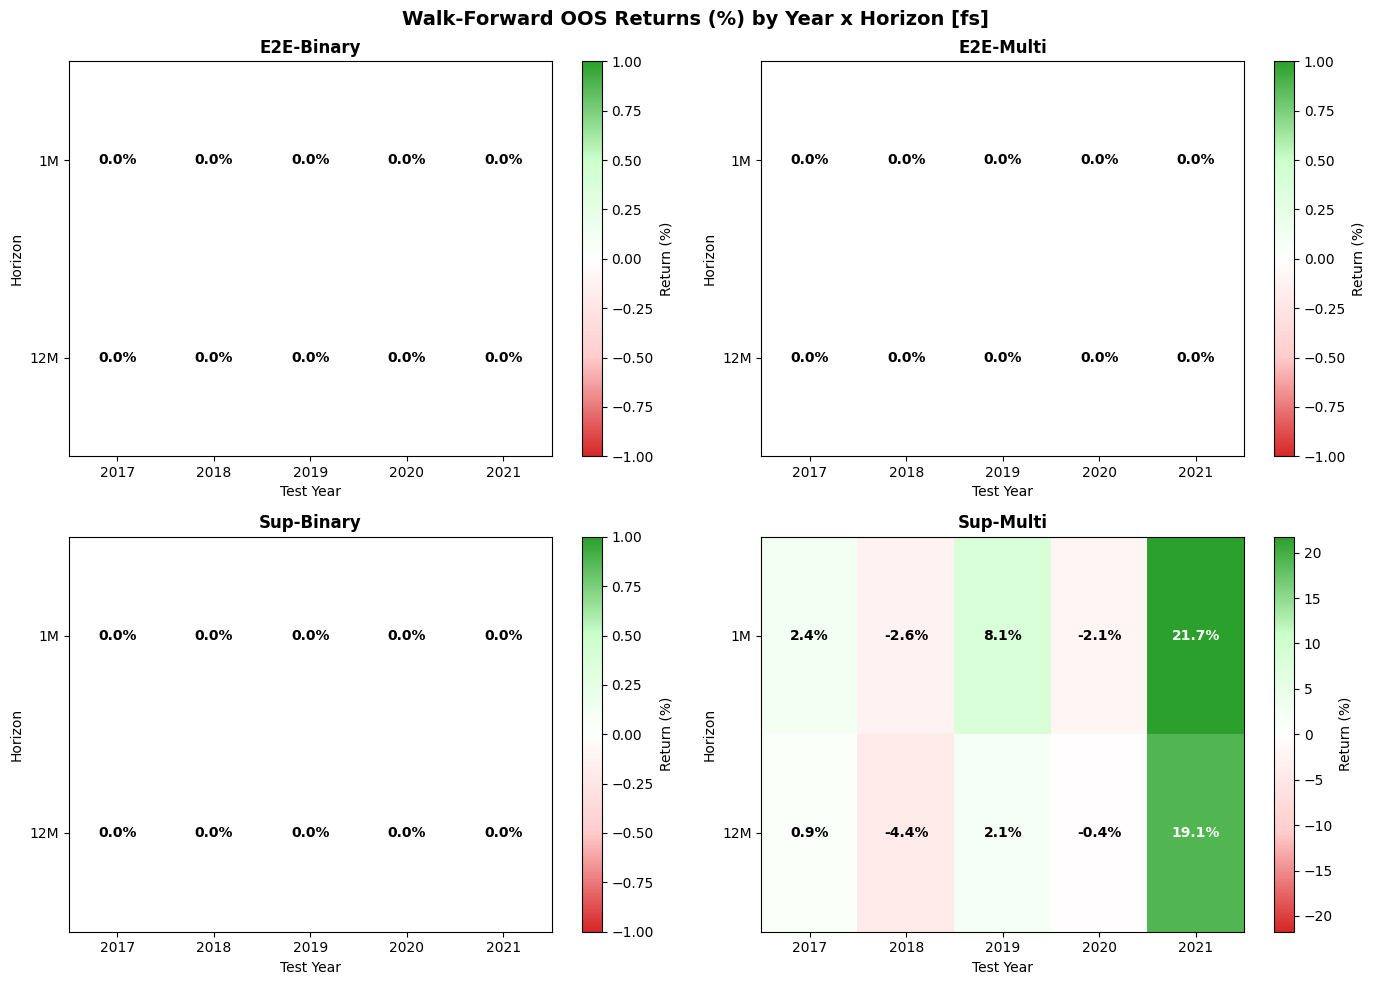

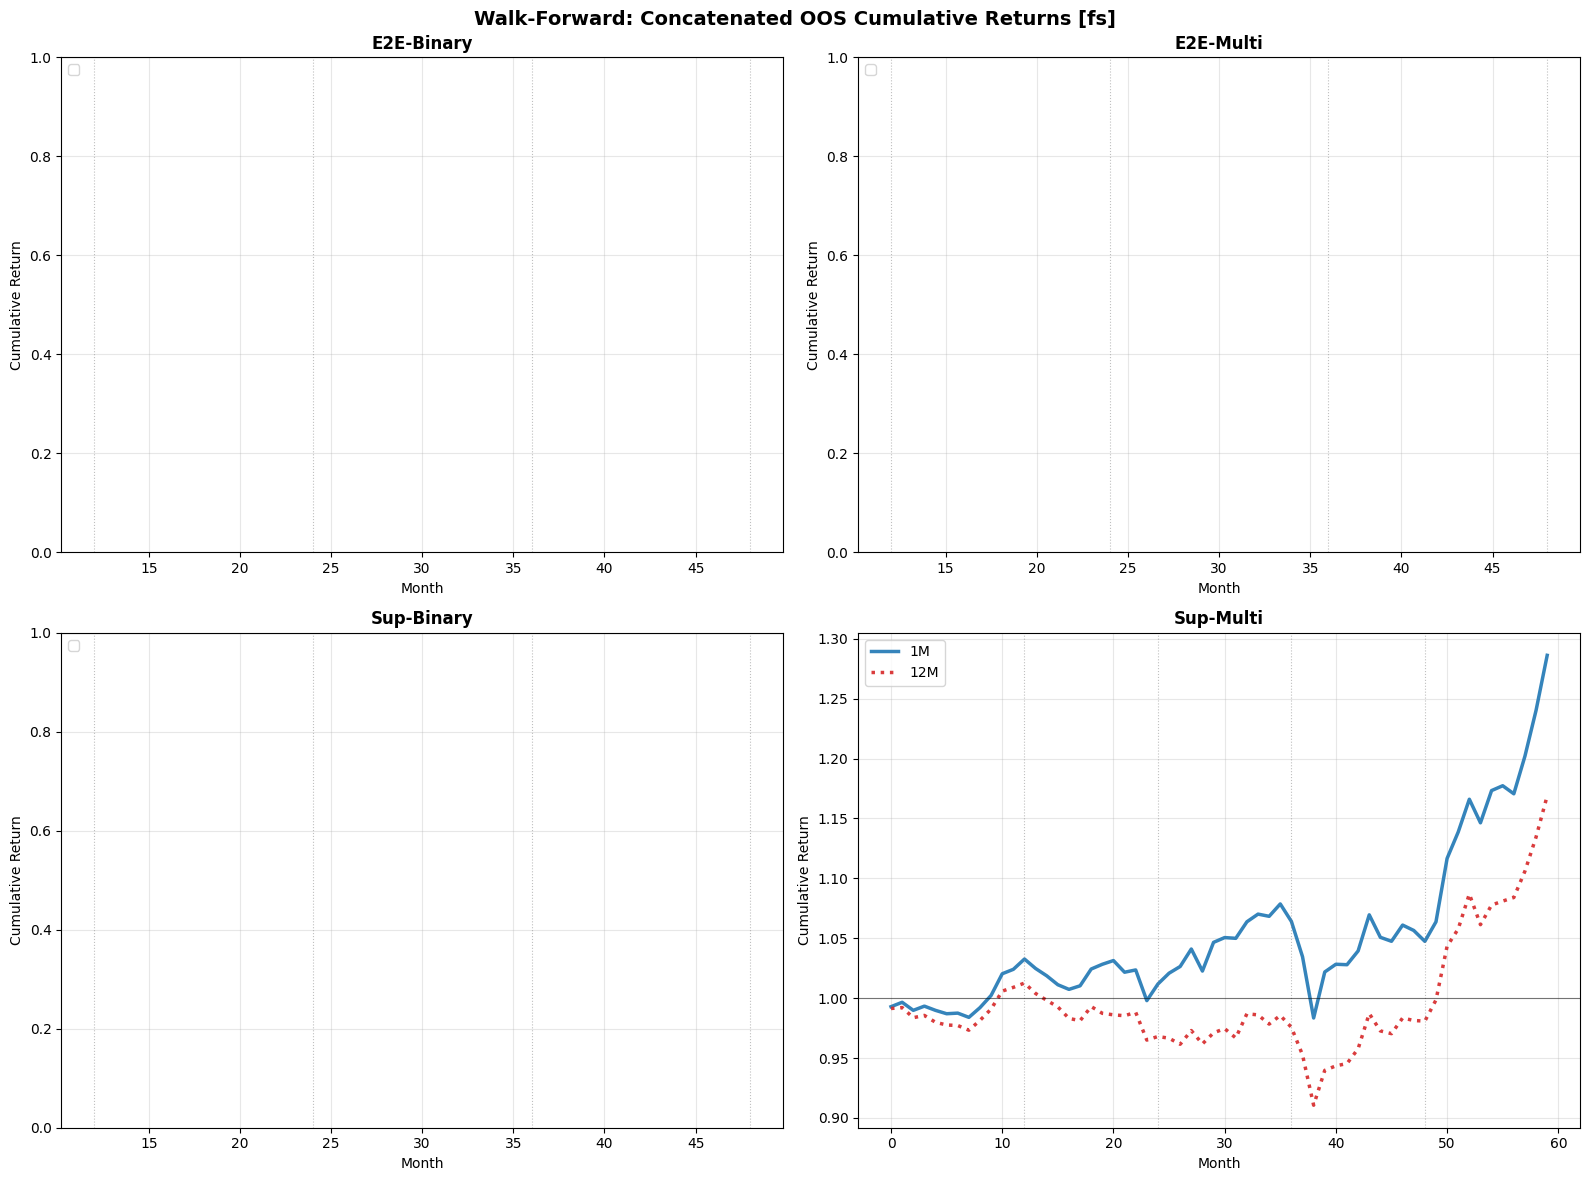

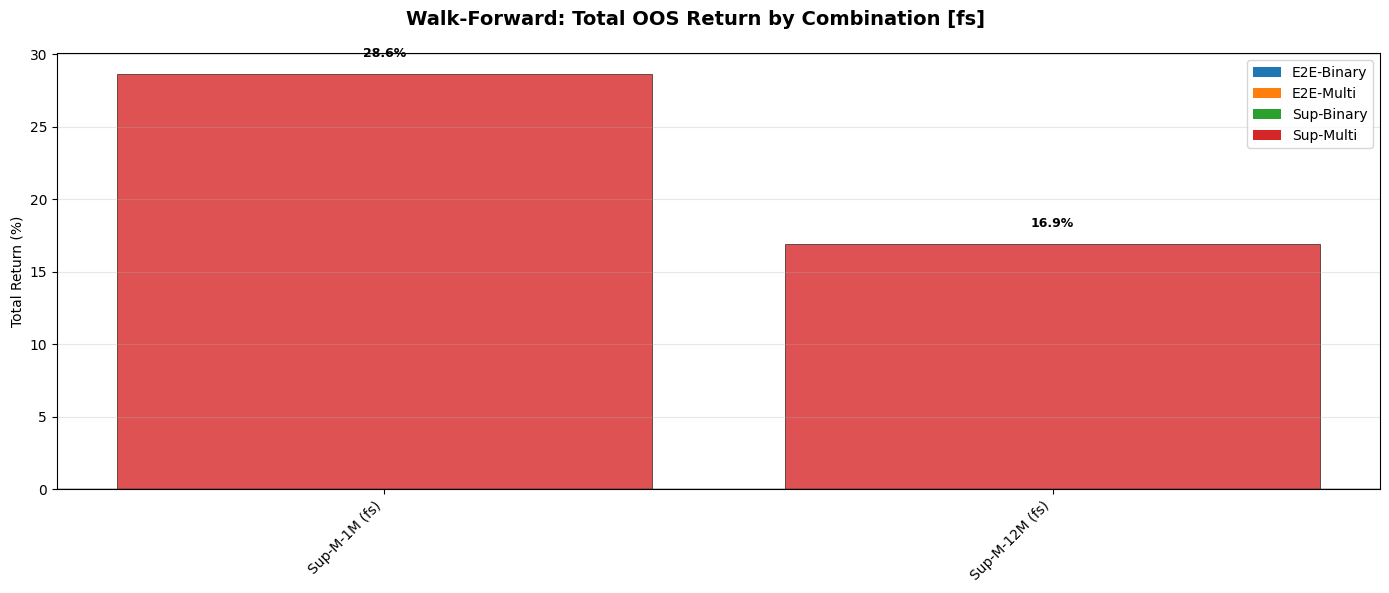

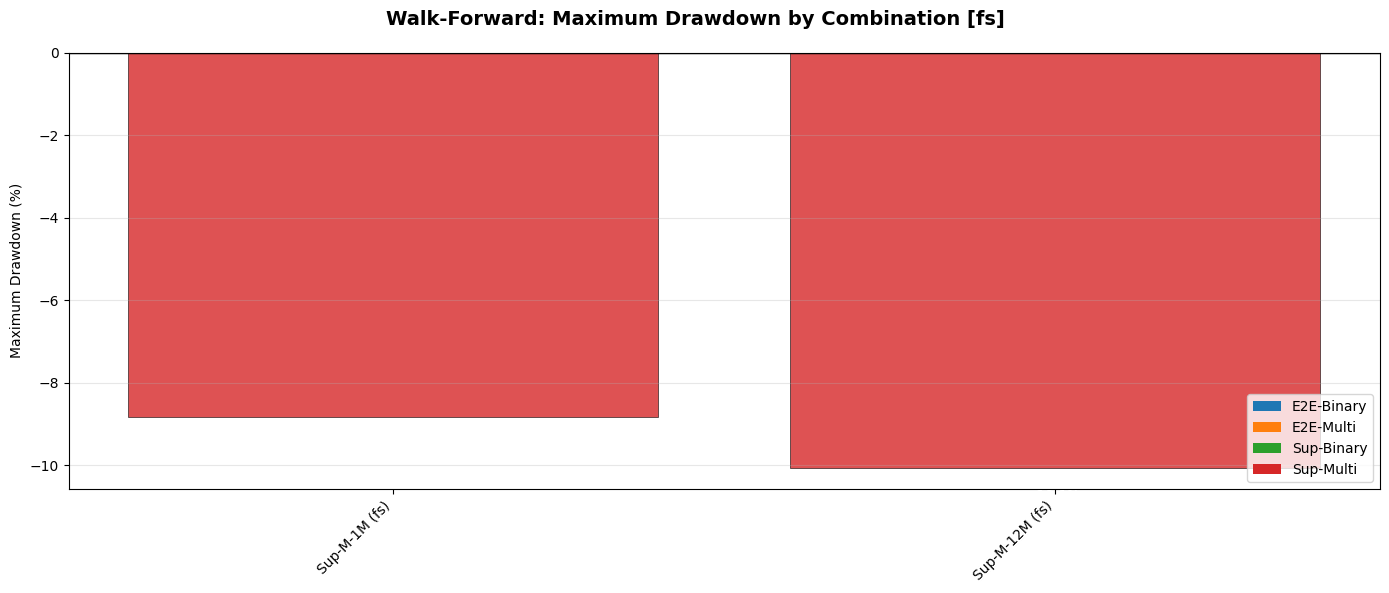


WALK-FORWARD SUMMARY BY YEAR [fs]

Combination                    2017      2018      2019      2020      2021       TOTAL      MAX DD
---------------------------------------------------------------------------------------------------
Sup-M-1M (fs)                  +2.4%      -2.6%      +8.1%      -2.1%     +21.7%       +28.6%        -8.8%
Sup-M-12M (fs)                 +0.9%      -4.4%      +2.1%      -0.4%     +19.1%       +16.9%       -10.1%

Walk-forward windows: 5 years
Total models trained: 10

Top 3 by Total Return:
  1. Sup-M-1M (fs): +28.6% (Max DD: -8.8%)
  2. Sup-M-12M (fs): +16.9% (Max DD: -10.1%)

Top 3 by Lowest Drawdown:
  1. Sup-M-1M (fs): -8.8% (Total Ret: +28.6%)
  2. Sup-M-12M (fs): -10.1% (Total Ret: +16.9%)

WALK-FORWARD SUMMARY BY YEAR [fs]

Combination                    2017      2018      2019      2020      2021       TOTAL      MAX DD
---------------------------------------------------------------------------------------------------
Sup-M-1M (fs)            

In [15]:
# ============================================================
# WALK-FORWARD RESULTS
# ============================================================

print("\n" + "=" * 80)
print("WALK-FORWARD SUMMARY (2017-2021)")
print("=" * 80)

# Get configs in results
configs_in_results = list(set(
    key[3] if len(key) == 4 else "baseline"
    for key in all_wf_results.keys()
))

# Plot
config_filter = None if len(configs_in_results) > 1 else configs_in_results[0]
plot_all_walk_forward(all_wf_results, config_filter=config_filter)
print_year_summary_table(all_wf_results, config_filter=config_filter)


HOLDOUT RESULTS (2022+)


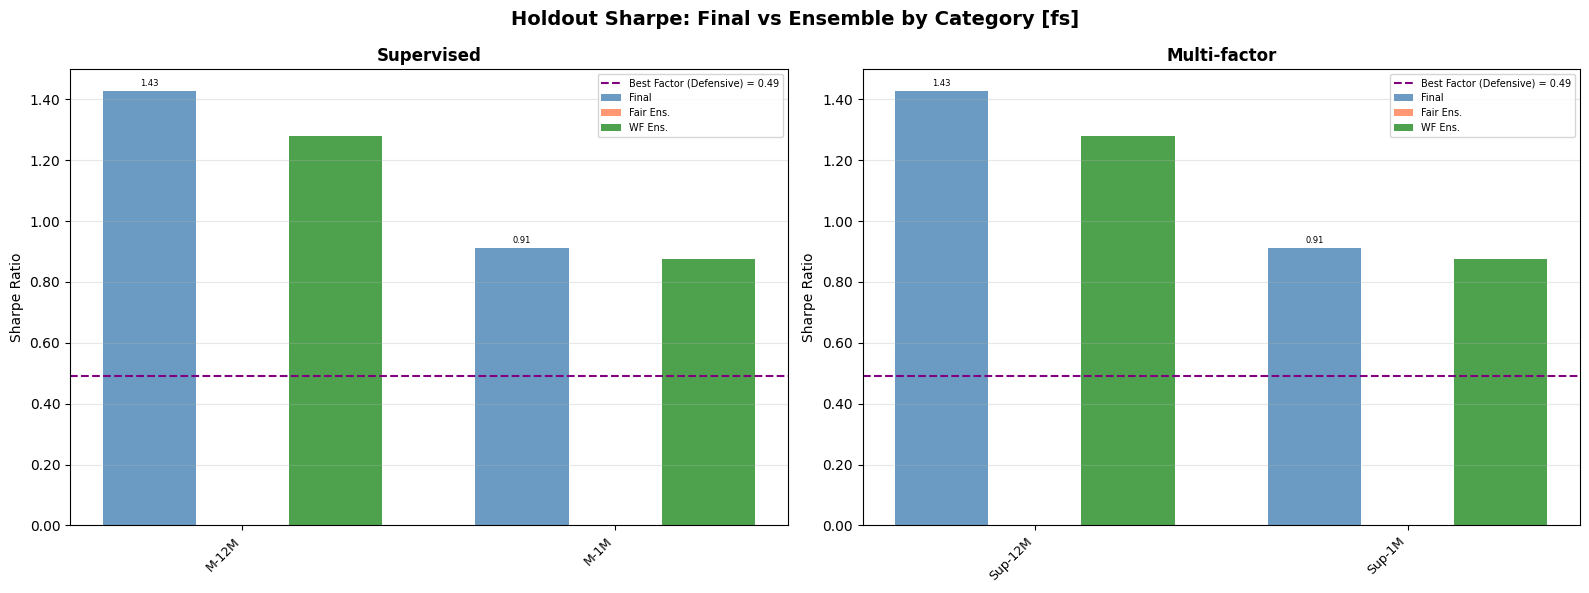

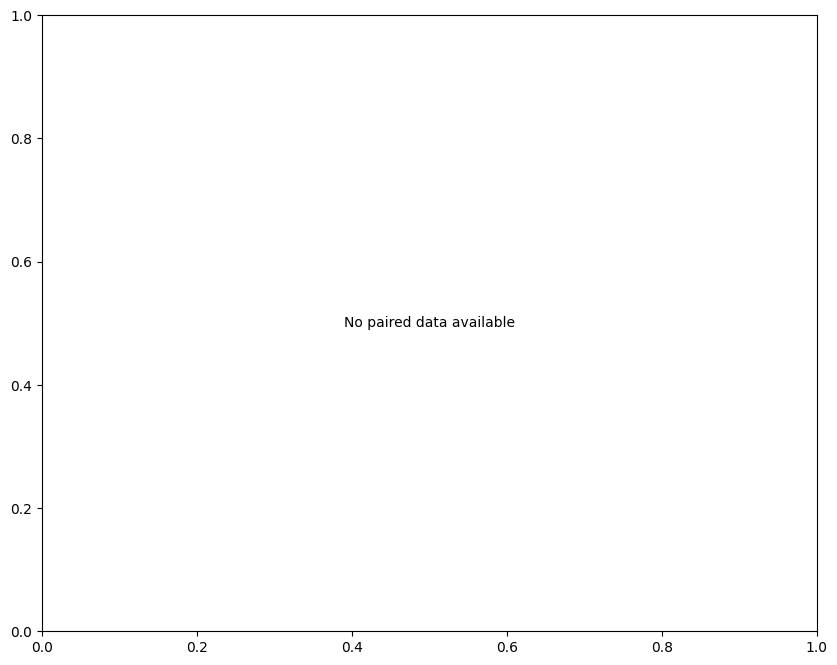

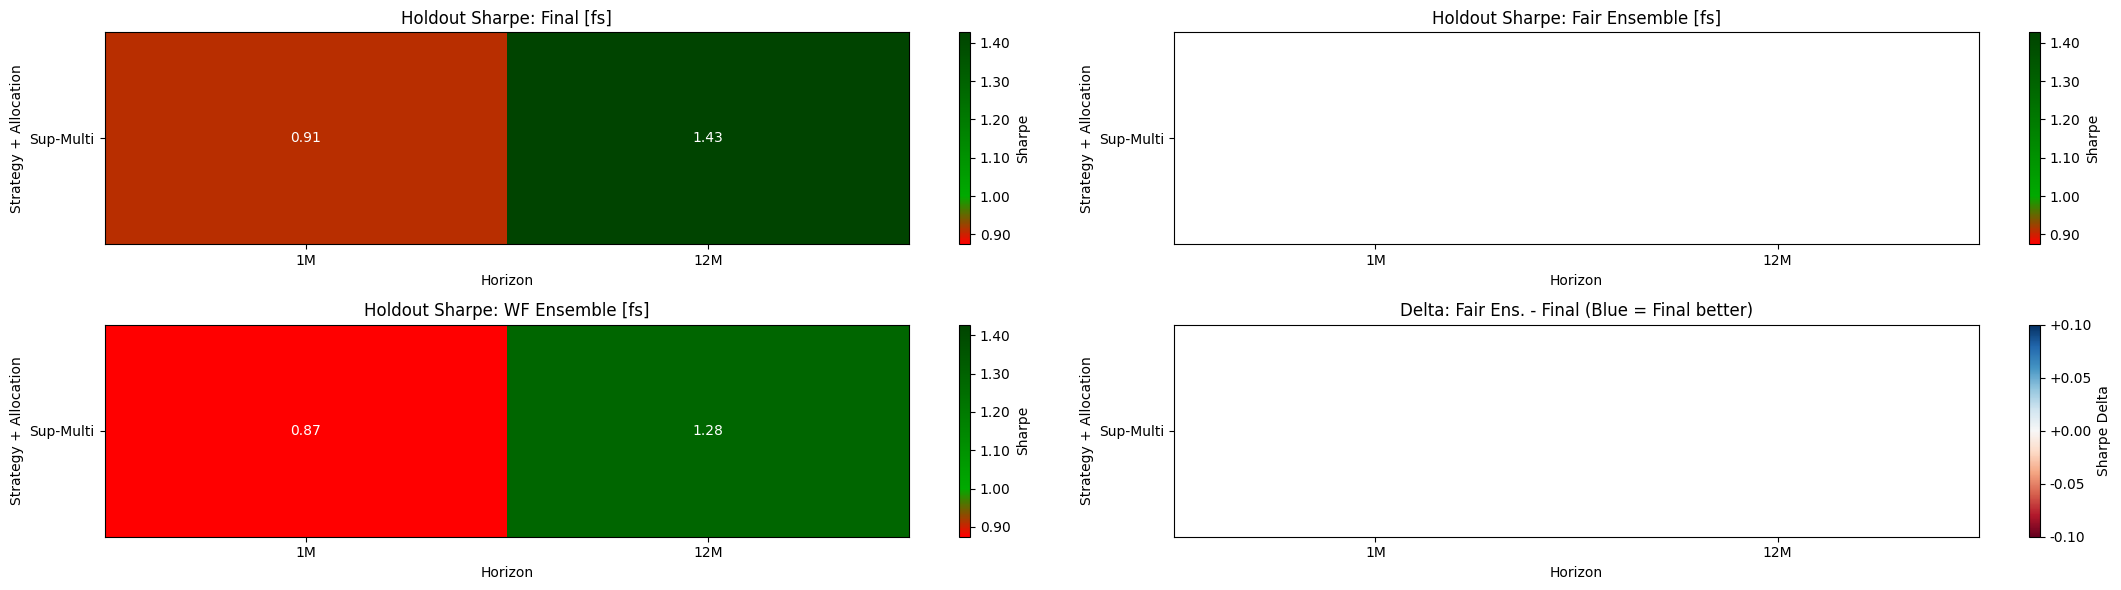

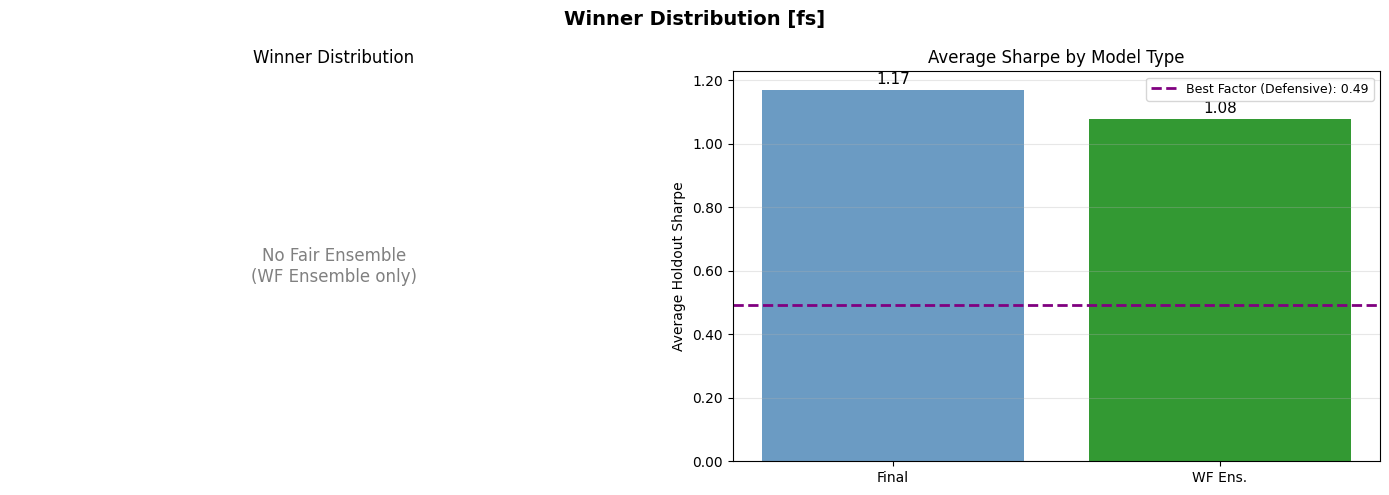

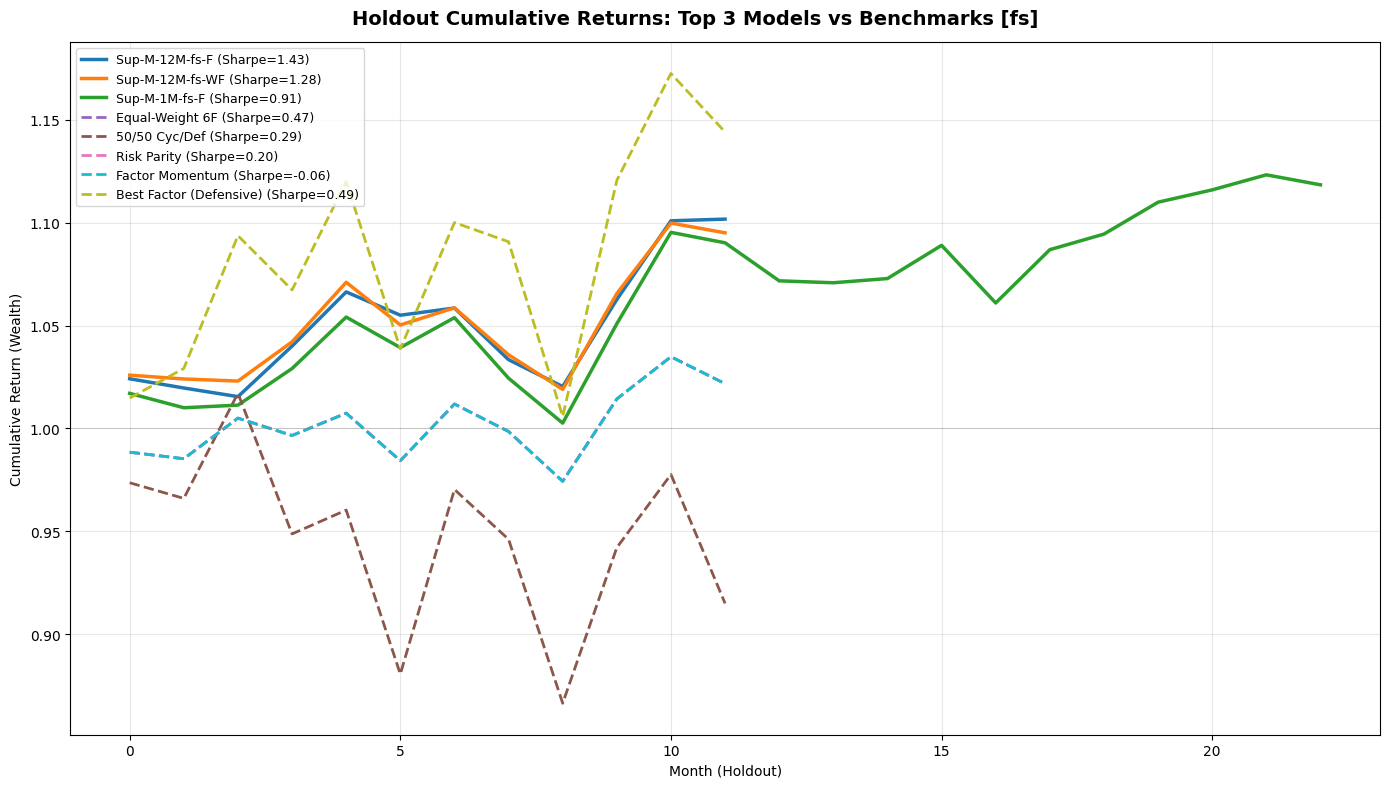


COMPLETE HOLDOUT RESULTS (with Composite Score) [fs]

Label              Strategy Alloc   H    Type           Sharpe       IC      MaxDD     Return    Score   Rank
------------------------------------------------------------------------------------------------------------------------
Sup-M-12M-fs-WF    Sup      Multi   12M   WF Ens.         +1.28    +52.9%      -4.9%      +9.5%    70.3%      1
Sup-M-1M-fs-WF     Sup      Multi   1M   WF Ens.         +0.87    +19.6%      -5.0%     +11.1%    54.8%      2
Sup-M-1M-fs-F      Sup      Multi   1M   Final           +0.91    -12.4%      -4.9%     +11.8%    46.9%      3
Sup-M-12M-fs-F     Sup      Multi   12M   Final           +1.43    -81.9%      -4.3%     +10.2%     0.0%      4

TOP 3 MODELS vs BENCHMARKS (Holdout Period) [fs]
Name                          Sharpe         IC      MaxDD       Return      Score
----------------------------------------------------------------------------------------------------
Sup-M-12M-fs-WF                +1.

In [16]:
# ============================================================
# HOLDOUT RESULTS
# ============================================================

print("\n" + "=" * 80)
print("HOLDOUT RESULTS (2022+)")
print("=" * 80)

# Compute benchmarks
holdout_start = pd.Timestamp("2022-01-01")
benchmarks = compute_all_benchmarks(factor_data, start_date=holdout_start)

# Plot
plot_all_holdout(
    all_holdout_results,
    horizons=HORIZONS,
    compute_score_fn=compute_composite_score,
    benchmarks=benchmarks,
    config_filter=config_filter,
)
print_holdout_summary_table(
    all_holdout_results, 
    compute_score_fn=compute_composite_score, 
    config_filter=config_filter
)

# Best models table
print_best_models_table(all_holdout_results, benchmarks)

# Summary
holdout_summary = evaluator._build_holdout_summary()
print_model_comparison_summary(holdout_summary)

In [ ]:
# ============================================================
# EXPORT RESULTS FOR DASHBOARD
# ============================================================

if str(project_root / "dashboard") not in sys.path:
    sys.path.insert(0, str(project_root))

from dashboard.export_results import (
    export_holdout_results_to_cache,
    export_walk_forward_results_to_cache,
    export_benchmarks_to_cache,
)

export_holdout_results_to_cache(all_holdout_results)
export_walk_forward_results_to_cache(all_wf_results)
export_benchmarks_to_cache(benchmarks)

print("\nResults exported! Run the dashboard with:")
print("  cd Strategies/factor_allocation_strategy_macro")
print("  streamlit run dashboard/app.py")